In [15]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import tqdm

### Define paths for the model and data of interest

In [2]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/profile/"
chrom_set = ["chr1"]
input_length = 1346
profile_length = 1000

In [17]:
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/profile/config/SPI1/SPI1_training_paths.json")
num_tasks = 4
num_strands = 2
controls = "matched"
model_class = profile_models.ProfilePredictorWithMatchedControls
noprior_model_path = os.path.join(model_base_path, "SPI1/1/model_ckpt_epoch_10.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/1/model_ckpt_epoch_10.pt")

In [4]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Import the model without priors
noprior_model = model_util.restore_model(model_class, noprior_model_path)
noprior_model.eval()
noprior_model = noprior_model.to(device)

In [6]:
# Import the model with priors
prior_model = model_util.restore_model(model_class, prior_model_path)
prior_model.eval()
prior_model = prior_model.to(device)

### Data preparation
Create an input data loader, that maps coordinates to data needed for the model

In [7]:
input_func = data_loading.get_profile_input_func(
    files_spec_path, input_length, profile_length, reference_fasta
)
pos_coords = data_loading.get_positive_profile_coords(
    files_spec_path, chrom_set=chrom_set
)

### Shap explainer
Create DeepSHAP explainers

In [20]:
noprior_shap_explainer = compute_shap.create_profile_explainer(
    noprior_model, input_length, profile_length, num_tasks, num_strands, controls
)

In [21]:
prior_shap_explainer = compute_shap.create_profile_explainer(
    prior_model, input_length, profile_length, num_tasks, num_strands, controls
)

### Plotting functions

In [25]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)
    plt.show()

In [26]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [28]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()
    plt.show()

### View predictions

In [31]:
def predict_and_plot(model, shap_explainer, chrom, start, end, seq_slice=slice(650, 750)):
    true_profs, log_pred_profs, true_counts, log_pred_counts, input_grads, \
        input_seqs = compute_predictions.get_profile_model_predictions(
            model, [(chrom, start, end)] * 50, num_tasks, input_func, controls,
            return_gradients=True, show_progress=False
        )

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    
    print("Profile predictions")
    plot_profiles(pred_prof_probs[0], true_prof_probs[0])
    print("Input gradient shape and Fourier transform")
    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=200)
    
    print("Input gradients")
    viz_sequence.plot_weights(input_grads[0][seq_slice])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])
    
    print("Shap scores")
    input_seqs, profiles = input_func([(chrom, start, end)] * 5)
    hyp_shap_scores = shap_explainer(
        input_seqs, profiles[:, num_tasks:], hide_shap_output=True
    )
    viz_sequence.plot_weights(hyp_shap_scores[0][seq_slice])
    viz_sequence.plot_weights((hyp_shap_scores[0] * input_seqs[0])[seq_slice])

In [12]:
# Sample some random peaks
pos_coords[np.random.choice(len(pos_coords), size=10, replace=False)]

array([['chr1', 221777392, 221777636],
       ['chr1', 11273339, 11273543],
       ['chr1', 111699373, 111699577],
       ['chr1', 67674325, 67674595],
       ['chr1', 23980282, 23980552],
       ['chr1', 161195185, 161195470],
       ['chr1', 116381056, 116381296],
       ['chr1', 231408739, 231409009],
       ['chr1', 236523856, 236524060],
       ['chr1', 50960142, 50960346]], dtype=object)

Profile predictions


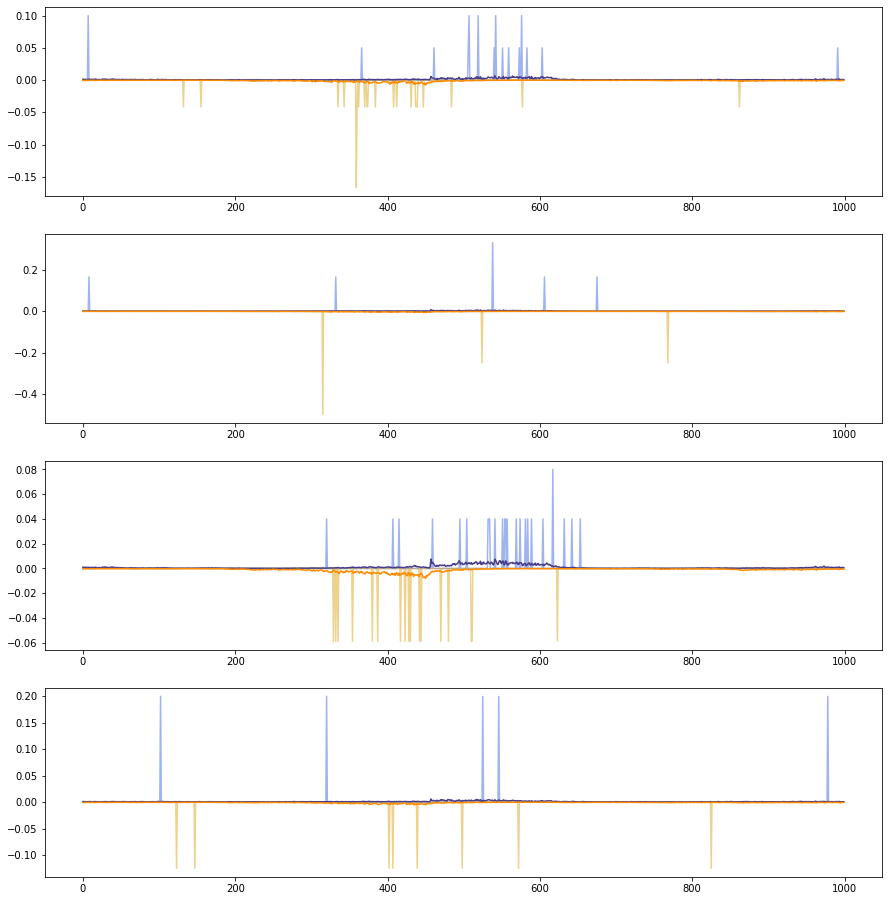

Input gradient shape and Fourier transform


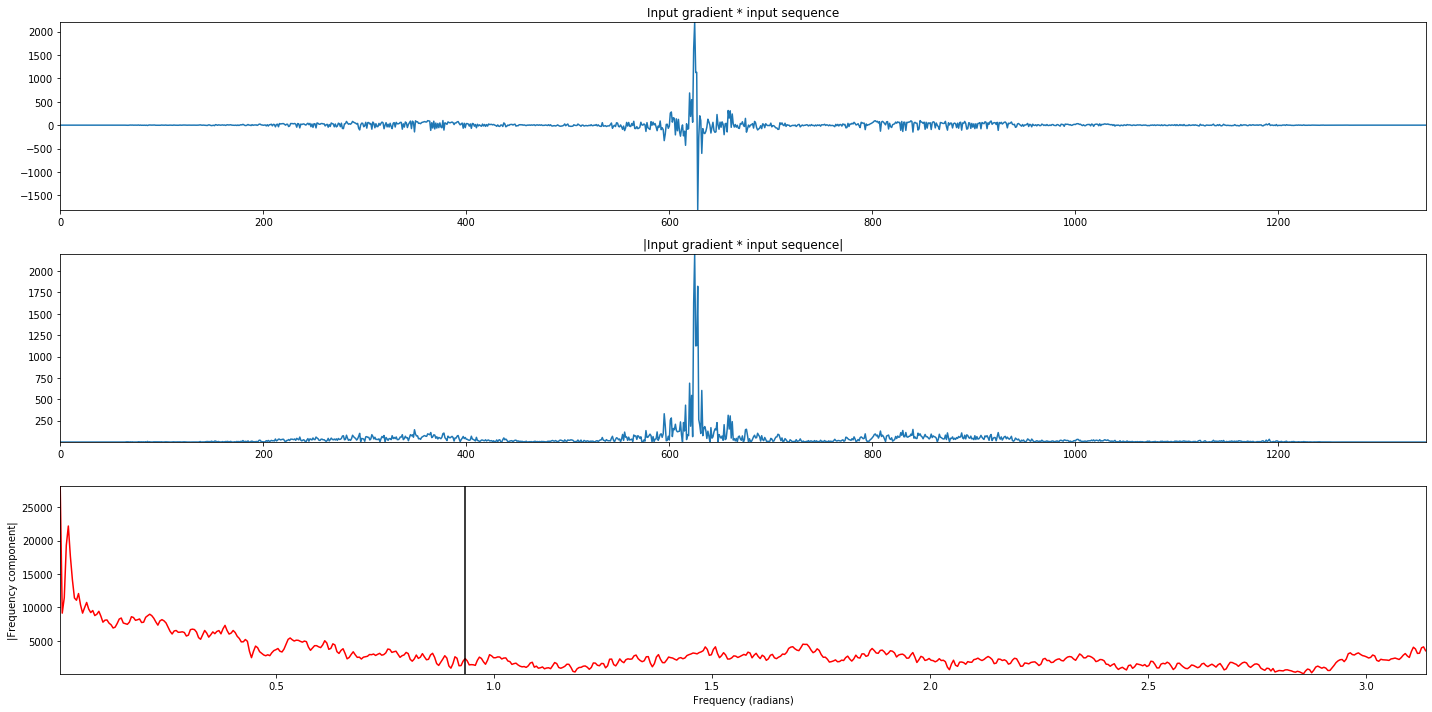

Input gradients


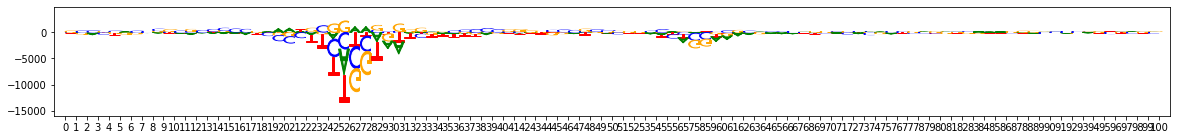

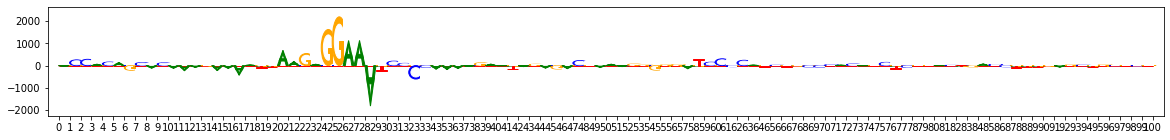

Shap scores


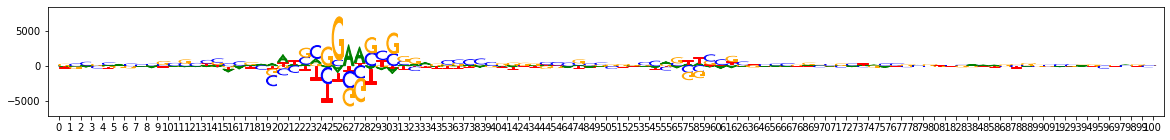

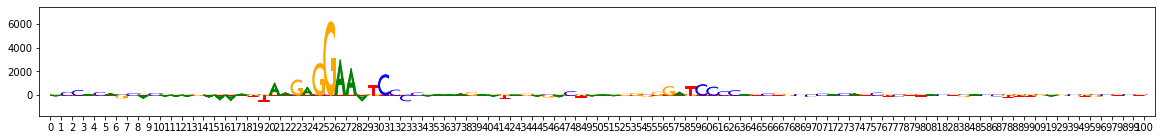

Profile predictions


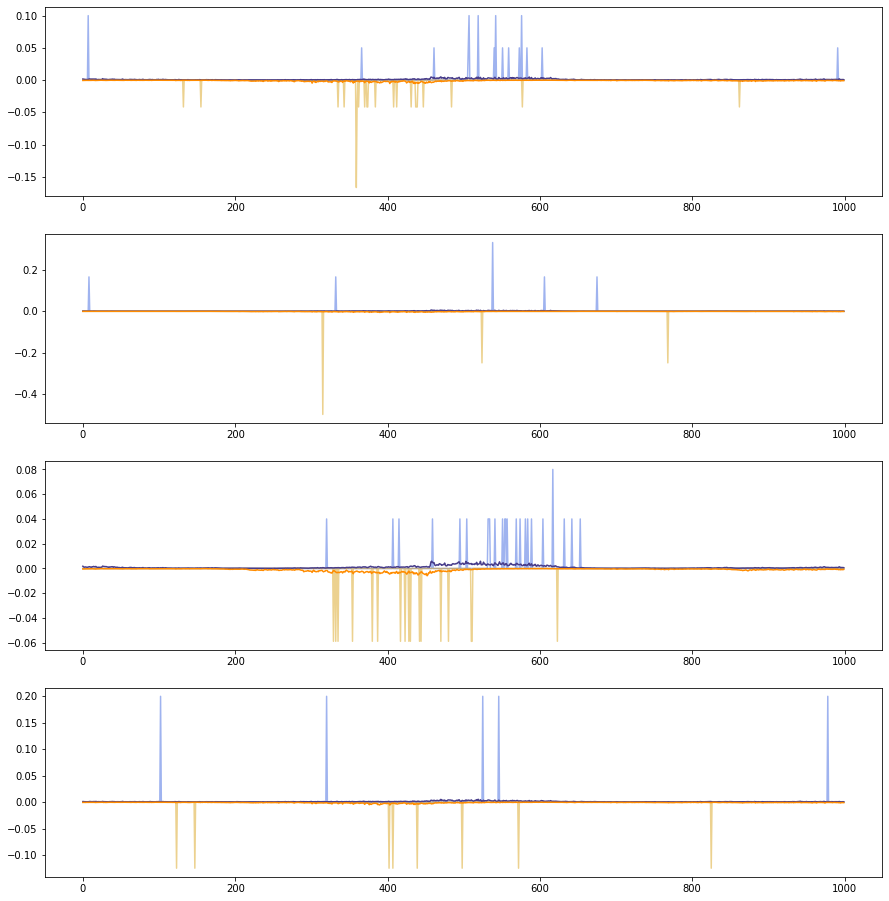

Input gradient shape and Fourier transform


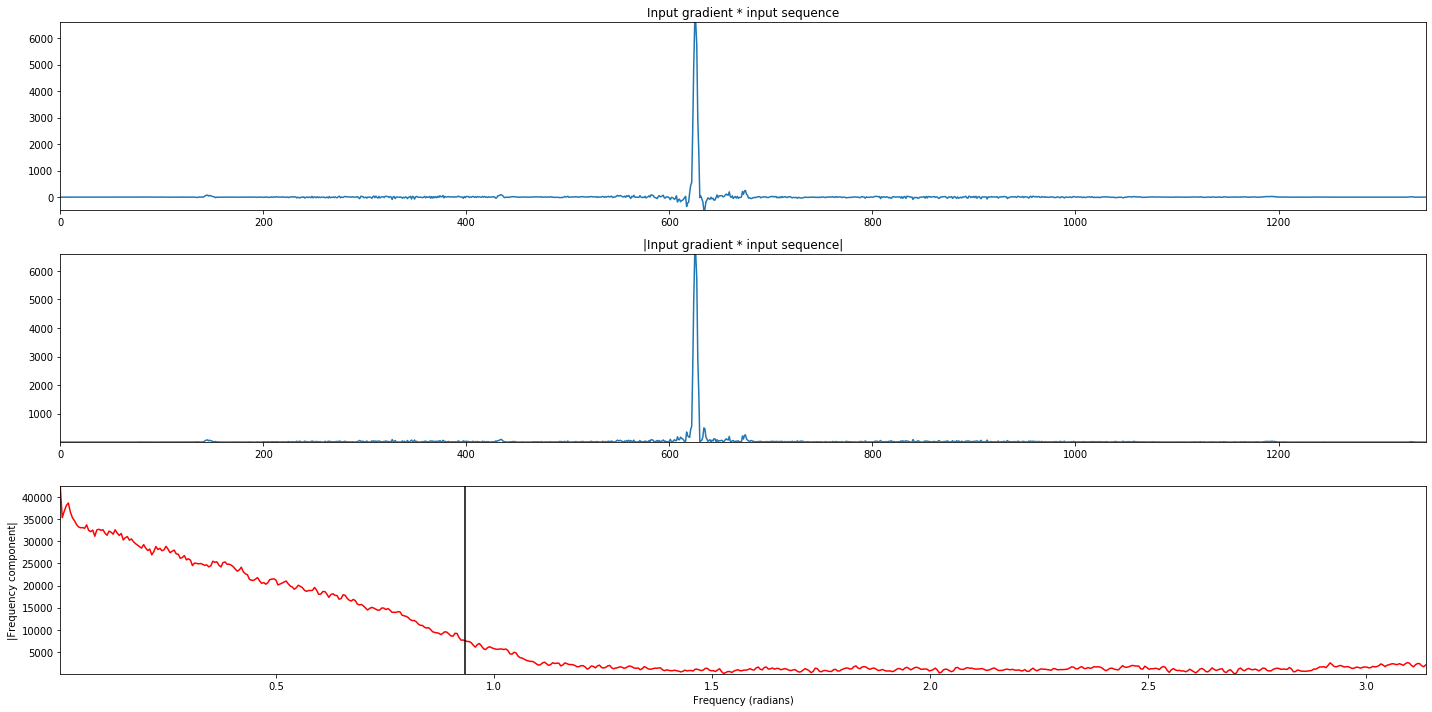

Input gradients


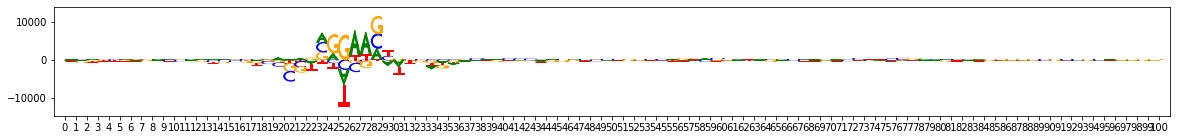

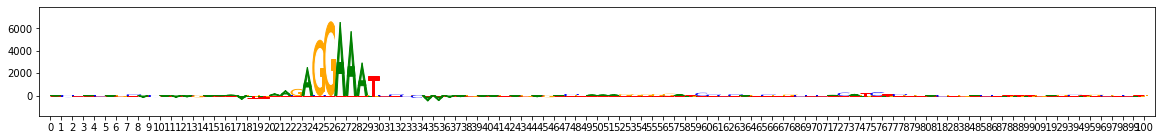

Shap scores


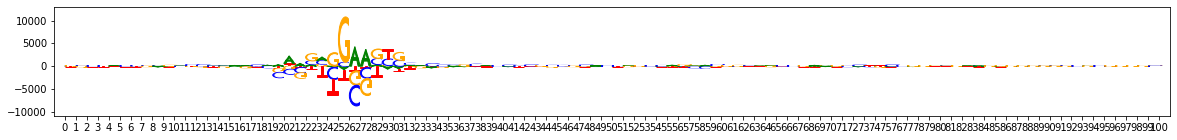

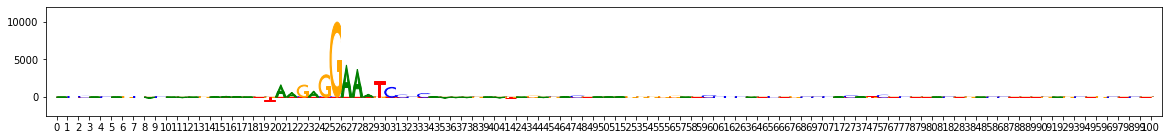

In [32]:
# SPI1
chrom, start, end = 'chr1', 119266483, 119266723
seq_slice = slice(600, 700)
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, seq_slice)

Profile predictions


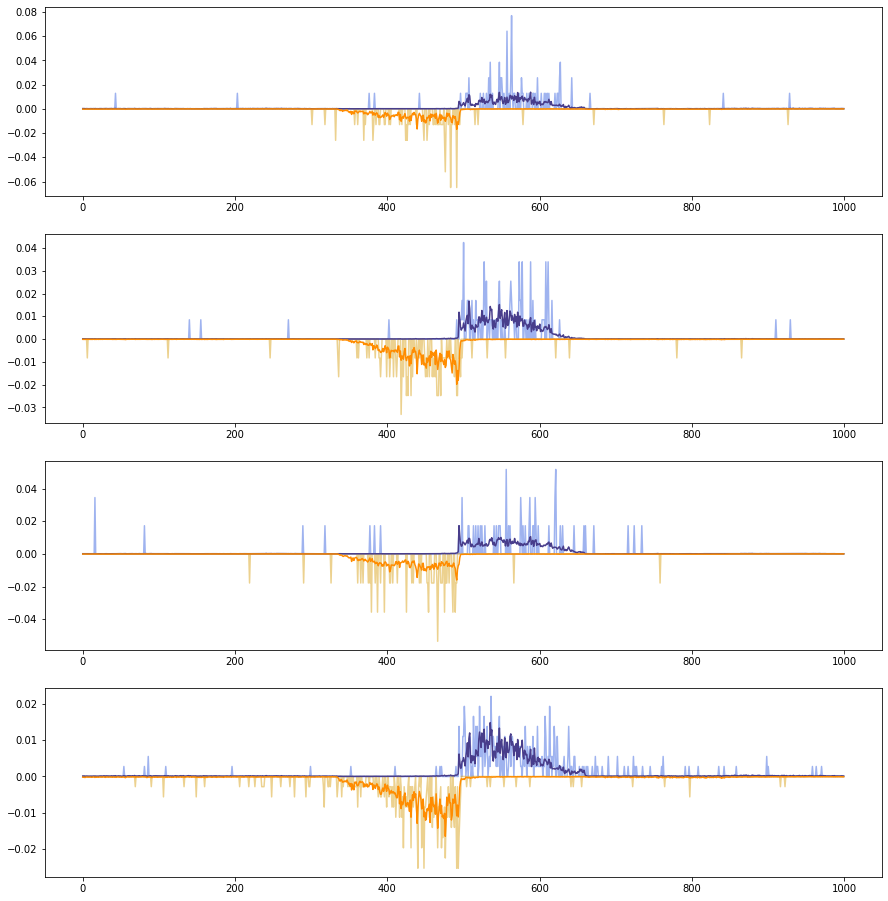

Input gradient shape and Fourier transform


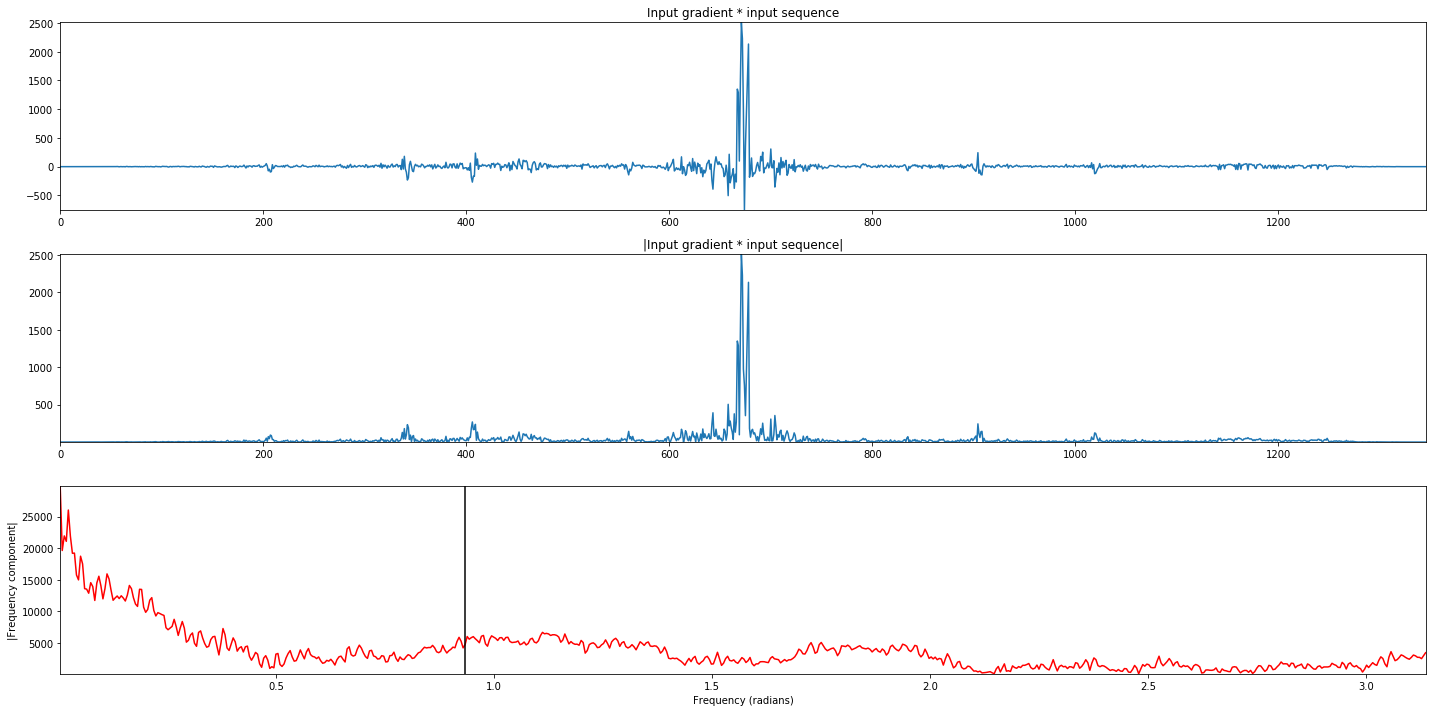

Input gradients


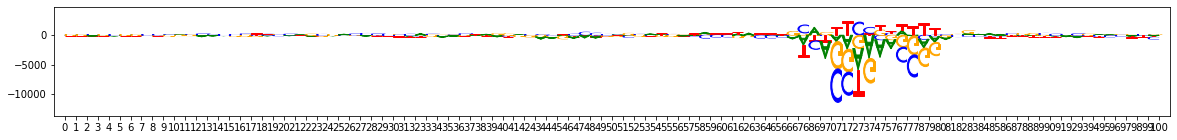

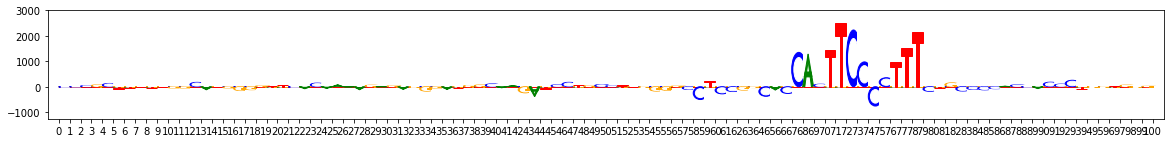

Shap scores


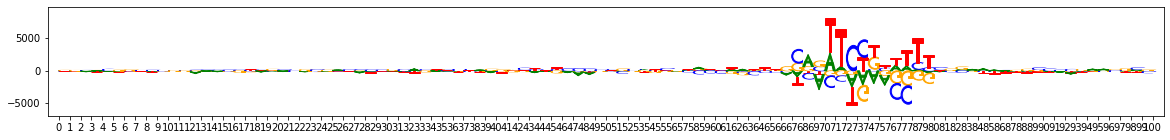

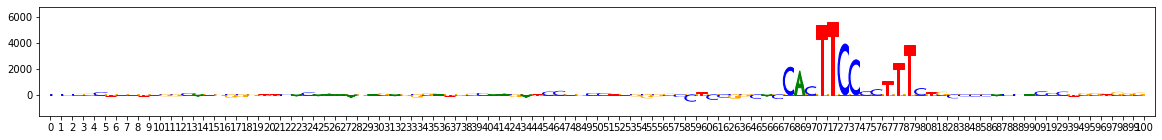

Profile predictions


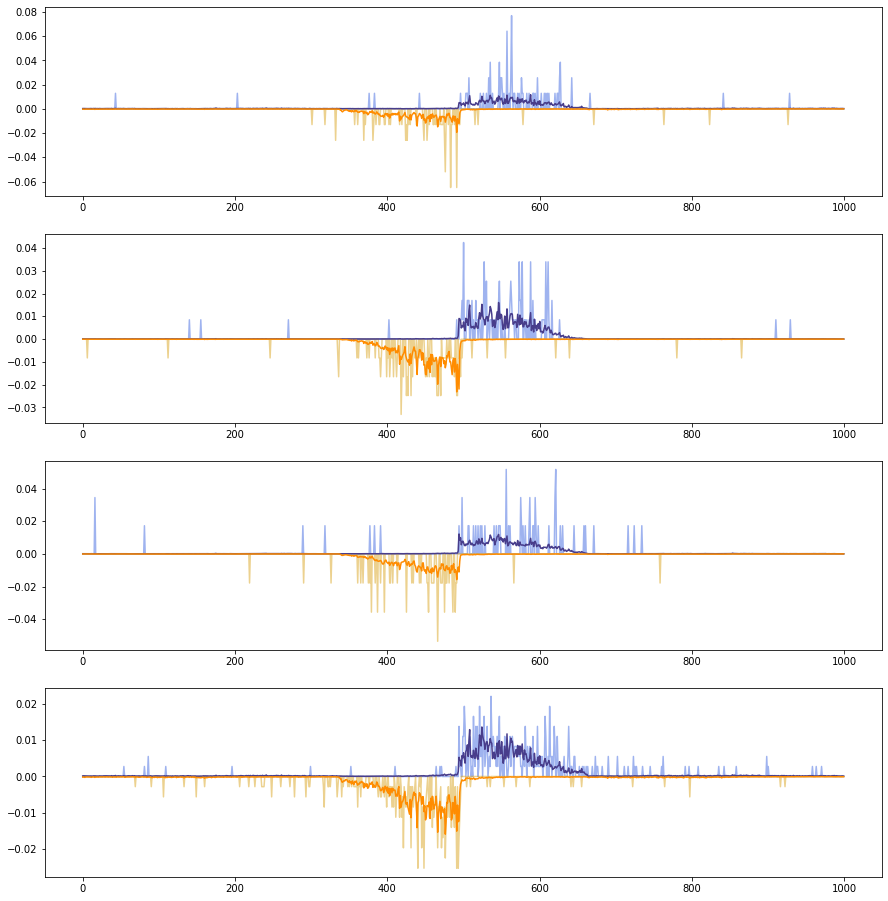

Input gradient shape and Fourier transform


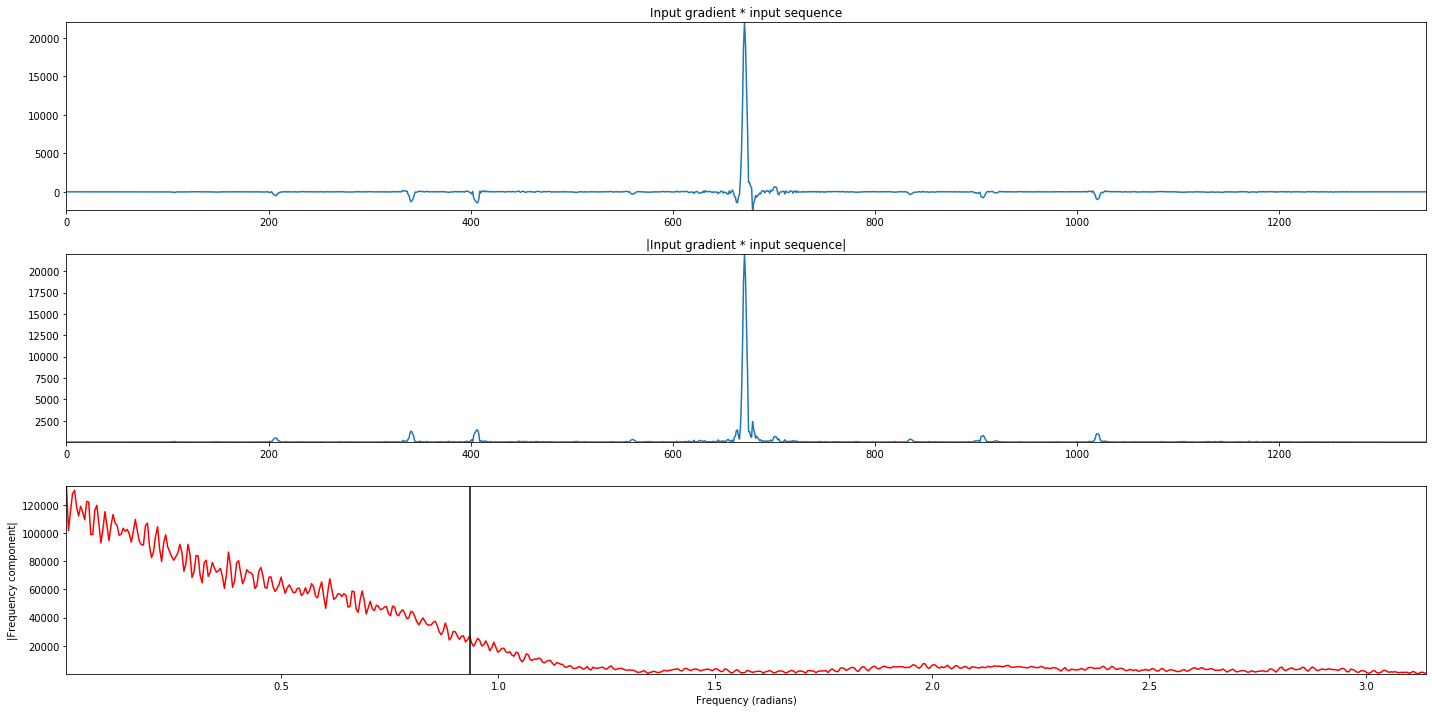

Input gradients


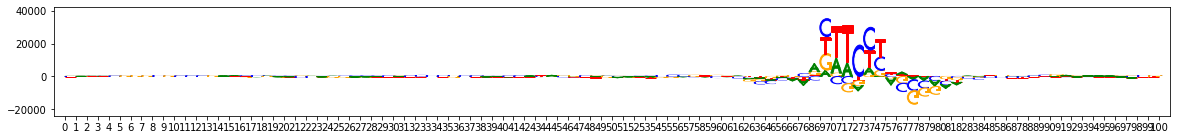

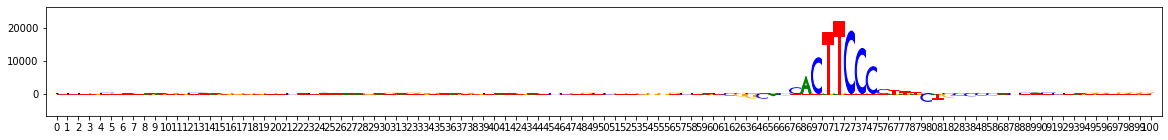

Shap scores


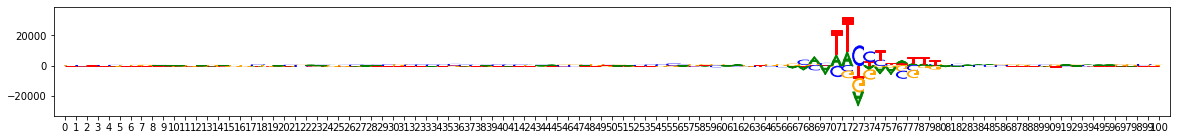

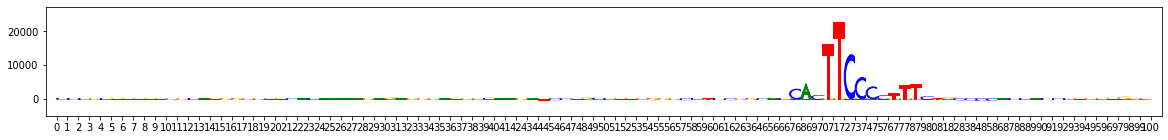

In [33]:
# SPI1
chrom, start, end = 'chr1', 162003813, 162003985
seq_slice = slice(600, 700)
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, seq_slice)